# Creando una superficies non-manifold con mallas de triángulos y lista de nodos master-slaves asociada


Creo 3 patches conformes y luego los uno en un solo archivo

In [1]:
pip install pyvista


The following command must be run outside of the IPython shell:

    $ pip install pyvista

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


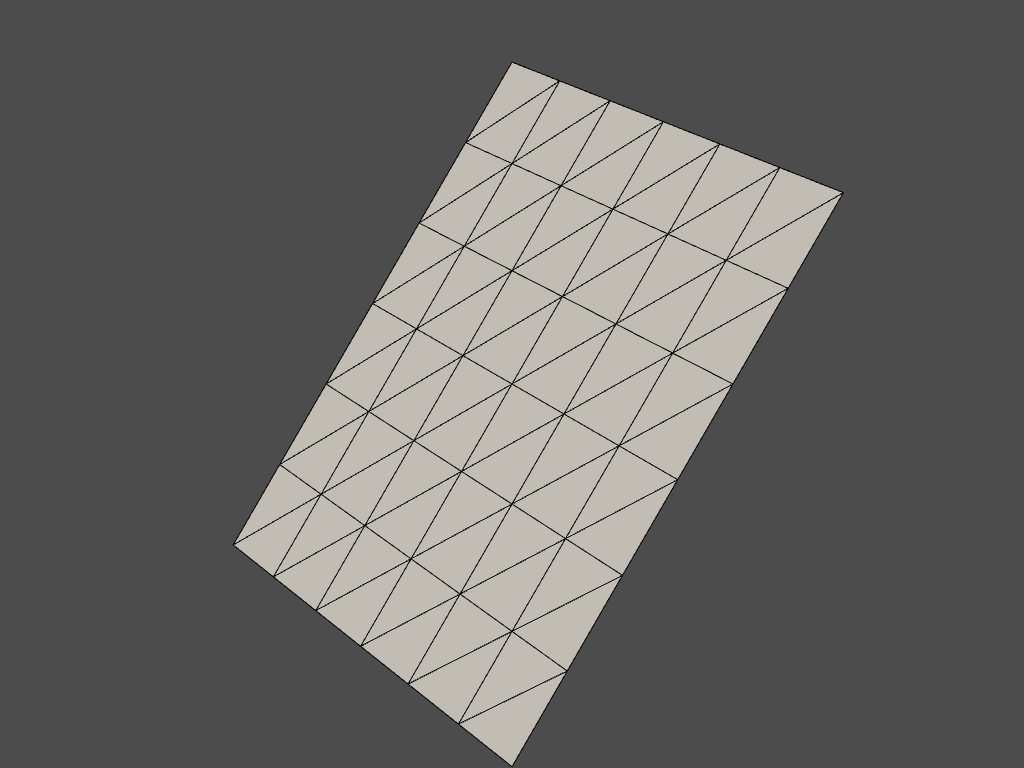

In [7]:
import pyvista as pv
import numpy as np


n = 7
x = np.linspace(-6, -2, num=n) 
y = np.linspace(-2, 2, num=n) 
xx, yy = np.meshgrid(x, y)
A, b = 100, 100
zz = -xx-4

points = np.c_[xx.reshape(-1), yy.reshape(-1), zz.reshape(-1)]
cloud = pv.PolyData(points)

surf = cloud.delaunay_2d()
surf.plot(show_edges=True)
surf.save("patch_1.vtk", binary=False)                            #opcional: guardar el patch en un archivo.vtk

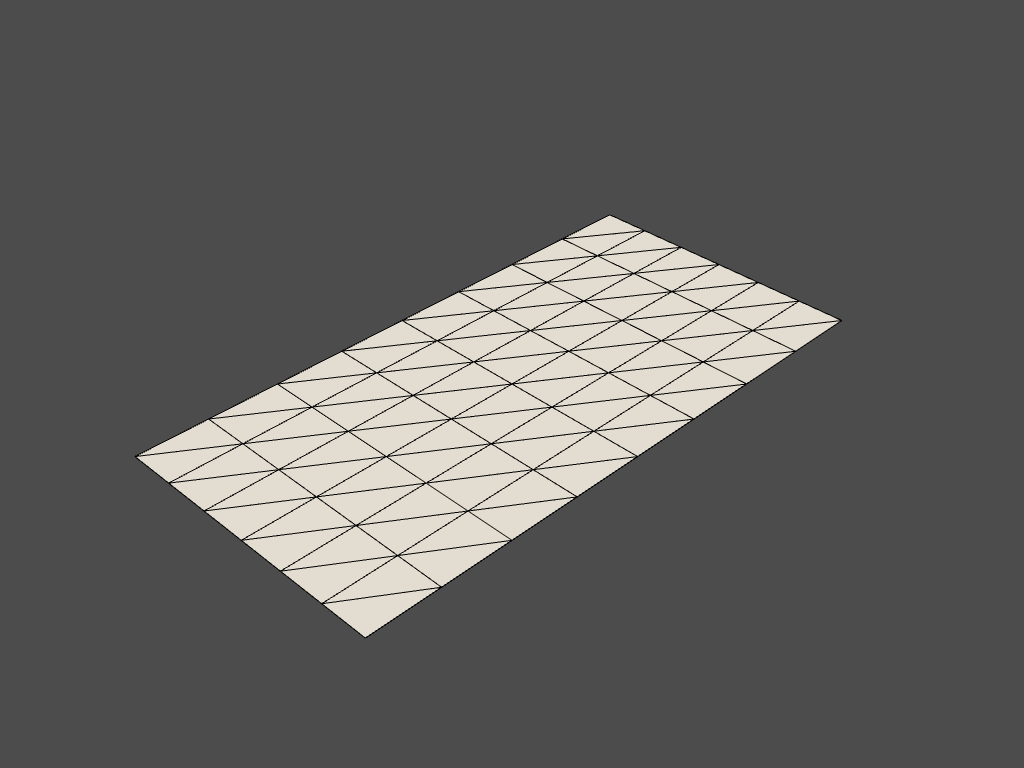

In [3]:
n = 7
x = np.linspace(-6, 2, num=n+2) 
y = np.linspace(-2, 2, num=n) 
xx, yy = np.meshgrid(x, y)
A, b = 100, 100
zz = xx*0-2

points = np.c_[xx.reshape(-1), yy.reshape(-1), zz.reshape(-1)]
cloud = pv.PolyData(points)

surf2 = cloud.delaunay_2d()
surf2.plot(show_edges=True)
#surf2.save("patch_2.vtk")                             #opcional: guardar el patch en un archivo.vtk

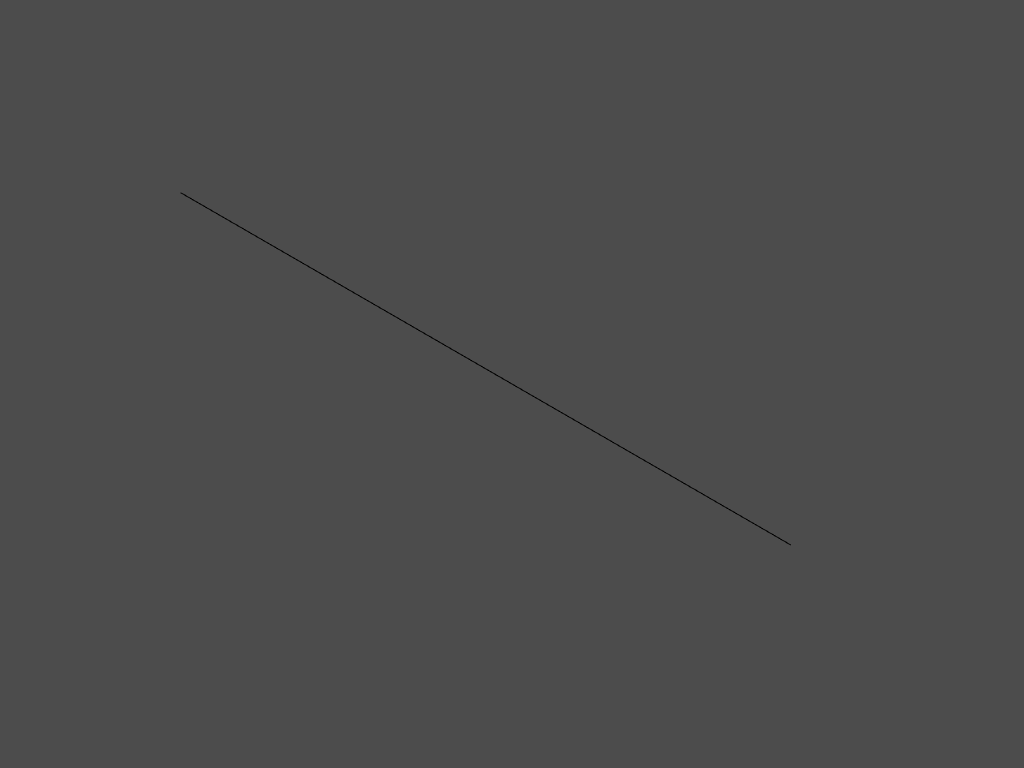

In [4]:
n = 7
x = np.linspace(-2, 2, num=n) 
y = np.linspace(-2, 2, num=n) 
xx, yy = np.meshgrid(x, y)
A, b = 100, 100
zz = xx

points = np.c_[xx.reshape(-1), yy.reshape(-1), zz.reshape(-1)]
cloud = pv.PolyData(points)

surf3 = cloud.delaunay_2d()
surf3.plot(show_edges=True)
#surf3.save("patch_3.vtk")                            #opcional: guardar el patch en un archivo.vtk

Ya tengo los 3 patches, ahora toca juntarlos en una sola malla...

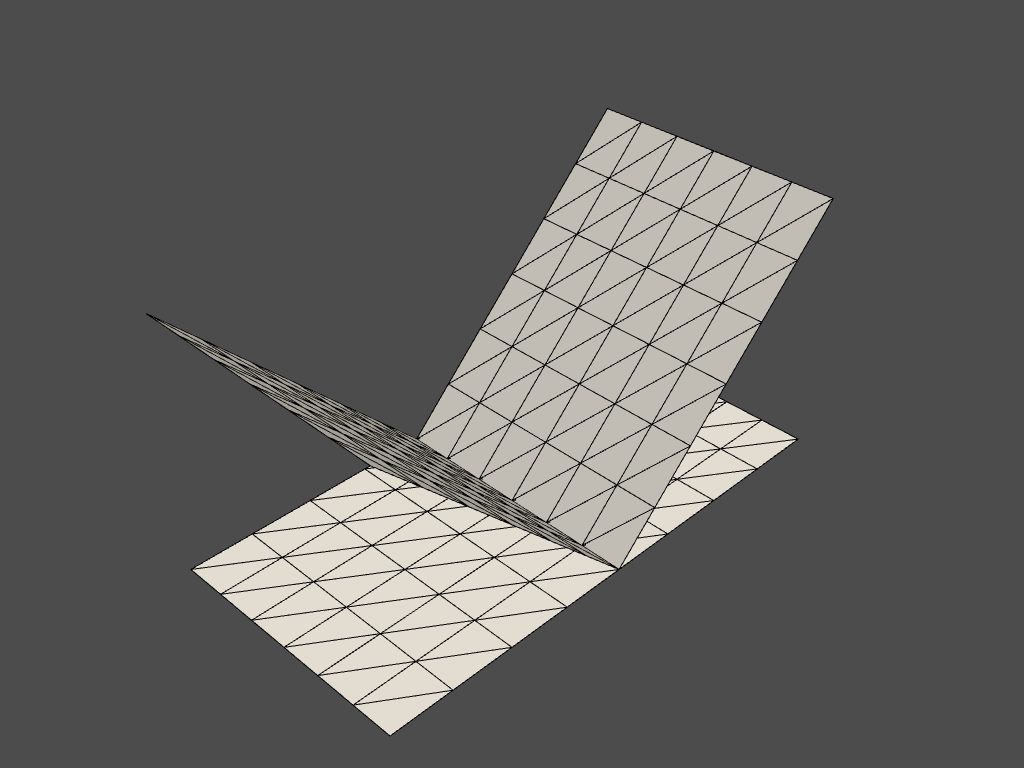

In [5]:
#Expresión alternativa sumando la lectura de varios patches guardados en archivos.vtk
#mesh = pv.read('patch_1.vtk')+pv.read('patch_2.vtk')+pv.read('patch_3.vtk')

mesh=surf+surf2+surf3                     # junto todos los patches
mesh.save('non_manifold_7.vtk', binary=False)           # guardo en un archivo.vtk
mesh.plot(show_edges=True)                # muestro un gráfico

# Para identificar non manifold nodes
Se crea un array que a cada nodo le asigna un Master:
* primero se buscan los nodos únicos
* si el nodo es único es su propio master
* si el nodo se repite:
 * el primer nodo es master
 * los siguientes son slaves, es decir tienen como master al primero en aparecer

In [1]:
import numpy as np
import vtk
from vtk.numpy_interface import dataset_adapter as dsa   # Para convertir de vtk a numpy

reader = vtk.vtkPolyDataReader()                         # SOURCE/READER 
reader.SetFileName('non_manifold_7.vtk')                   
reader.Update()                                          
data_vtk = reader.GetOutput()
data= dsa.WrapDataObject(data_vtk)                      # convierte la salida a array compatible con numpy

N_points = data.GetNumberOfPoints()                      # número de nodos
Points = np.array(data.Points)                           # nodos

unq, index = np.unique(data.Points,                      # filtro valores uniq del array de puntos
                       axis=0,                           # compara filas enteras
                       return_index=True)                # índice de los no repetidos

masters   = np.zeros(N_points,dtype=int)
is_slave  = np.zeros(N_points, dtype=int)
for i in range(0, N_points):                             # para cada nodo i
    if i in index:                                       # si es único
        masters[i] = i                                   # su master es i
        is_slave[i] = False                              
    else:                                                # si no es único
        for j in range(0,i):                             # comparo con cada nodo ANTERIOR  j
            if np.all(Points[i]==Points[j]):             # si es igual  al nodo j (el primero que aparece)
                masters[i] = j                           # su master es j
                is_slave[i] = True
                break                                    # detengo el bucle for
masters, is_slave , np.sum(is_slave) , np.all(Points==Points[masters])  # si da True el algoritmo para los masters funciona bien
## Altenativa !!!!!!
## hacer lista de índices repetidos... restando index de la lista total..
## todos los elementos son igual a su master
## para los elementos de la lista de los repetidos... buscar dentro de la lista de los repetidos...

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,   6,  54,  55,  56,  57,  58,  59,  60,  61,  13,  63,  64,
         65,  66,  67,  68,  69,  70,  20,  72,  73,  74,  75,  76,  77,
         78,  79,  27,  81,  82,  83,  84,  85,  86,  87,  88,  34,  90,
         91,  92,  93,  94,  95,  96,  97,  41,  99, 100, 101, 102, 103,
        104, 105, 106,  48, 108, 109, 110, 111,   6, 113, 114, 115, 116,
        117, 118,  13, 120, 121, 122, 123, 124, 125,  20, 127, 128, 129,
        130, 131, 132,  27, 134, 135, 136, 137, 138, 139,  34, 141, 142,
        143, 144, 145, 146,  41, 148, 149, 150, 151, 152, 153,  48, 155,
        156, 157, 158, 159, 160]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0

In [ ]:
Cells=Cells.reshape(int(len(Cells)/4),4)
surf = pv.PolyData(Points, Cells)
surf.plot(show_edges=True)

## Identifico bordes "Creases"

In [2]:
bordes = vtk.vtkFeatureEdges()                     
bordes.SetInputData(data_vtk)   
bordes.BoundaryEdgesOn()                           
bordes.FeatureEdgesOff()
bordes.Update()
b=bordes.GetOutput()
b.GetNumberOfPoints()

67

In [3]:
is_creases=np.zeros(N_points, dtype=int)          # array boolean vacío
for i in range(0,N_points):                       # Para cada nodo de la malla  i
    p=data_vtk.GetPoint(i)                        # obtengo  su posición [x,y,z]  
    B_point=b.GetPoint(b.FindPoint(p))            # de los puntos del borde, busco el más cercano [a x,y,z]
    val=B_point==p                                # verifico si ese nodo es del borde
    is_creases[i]=val                             # guarda 1 si es del borde, 0 si no
is_creases, len(is_creases), sum(is_creases)      # hay creases repetidos por master-slave

(array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1]), 161, 81)

Filtrando algunos puntos según sus valores en (x, y, z) para fijar condiciones de contorno

In [4]:
from vtk.numpy_interface import dataset_adapter as dsa
data = dsa.WrapDataObject(data_vtk)
puntos=np.array(data.Points)


#selecciono puntos con z=0   bordes superiores
bound0=np.array(puntos[:,2]==0, dtype=int)

#puntos con z=-2 y x=-6      borde inferior izquierdo
bound1=np.array((np.array(puntos[:,2]==-2, dtype=int)+  np.array(puntos[:,0]==-6,dtype=int))>1,dtype=int)

#puntos con z=-2 y x=2       borde inferior derecho
bound2=np.array((np.array(puntos[:,2]==-2, dtype=int)+  np.array(puntos[:,0]==2,dtype=int))>1, dtype=int)


bound0, bound1, bound2, len(bound0)

(array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

Todos los nodos en los que se fijan Boundary Conditions se guardan en un archivo    *BNodes.vtk  ???

guardo en un vector is_constrained

In [7]:
is_constrained=((bound0+bound1+bound2*2)!=0).astype(int)
is_constrained, sum(is_constrained)

(array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0]), 28)

In [8]:
bound = bound0+bound1+bound2      # array boolean de todos los nodos con BC
puntosBC=np.zeros([sum(bound),3])

num=0

nodes=np.zeros(sum(bound))
Points = vtk.vtkPoints()          # vtkPoints
for i in range(0, len(bound)):
    if bound[i]:
        puntosBC[num,:]=data_vtk.GetPoint(i)
        Points.InsertNextPoint(data_vtk.GetPoint(i))
        nodes[num]=i
        num+=1
puntosBC, puntosBC.shape, nodes

(array([[-4.        , -2.        ,  0.        ],
        [-4.        , -1.33333333,  0.        ],
        [-4.        , -0.66666667,  0.        ],
        [-4.        ,  0.        ,  0.        ],
        [-4.        ,  0.66666667,  0.        ],
        [-4.        ,  1.33333333,  0.        ],
        [-4.        ,  2.        ,  0.        ],
        [-6.        , -2.        , -2.        ],
        [ 2.        , -2.        , -2.        ],
        [-6.        , -1.33333333, -2.        ],
        [ 2.        , -1.33333333, -2.        ],
        [-6.        , -0.66666667, -2.        ],
        [ 2.        , -0.66666667, -2.        ],
        [-6.        ,  0.        , -2.        ],
        [ 2.        ,  0.        , -2.        ],
        [-6.        ,  0.66666667, -2.        ],
        [ 2.        ,  0.66666667, -2.        ],
        [-6.        ,  1.33333333, -2.        ],
        [ 2.        ,  1.33333333, -2.        ],
        [-6.        ,  2.        , -2.        ],
        [ 2.        

In [18]:
BCs=dsa.numpyTovtkDataArray(puntosBC,name = "boundary points") # convierto la lista master a un objeto vtkDataArray 

polydata = vtk.vtkPolyData()                                   # creo un objeto vtkPolyData                 
polydata.SetPoints(Points)                                

NodesId=dsa.numpyTovtkDataArray(nodes, name="NodesId")
polydata.GetPointData().AddArray(NodesId)

writer = vtk.vtkPolyDataWriter()                               # creo el objeto PolyDataWriter
writer.SetFileName('BNodes.vtk')     

writer.SetInputData(polydata)                                  # le conecto los datos data_vtk
writer.SetFileType(1)                                          # opcional: set file type to ascii
print(writer.Write())                                          # escribo el archivo .vtk  Returns 1 on success and 0 on failure.
del(writer)

1


In [19]:
!cat BNodes.vtk

# vtk DataFile Version 5.1
vtk output
ASCII
DATASET POLYDATA
POINTS 28 float
-4 -2 0 -4 -1.33333 0 -4 -0.666667 0 
-4 0 0 -4 0.666667 0 -4 1.33333 0 
-4 2 0 -6 -2 -2 2 -2 -2 
-6 -1.33333 -2 2 -1.33333 -2 -6 -0.666667 -2 
2 -0.666667 -2 -6 0 -2 2 0 -2 
-6 0.666667 -2 2 0.666667 -2 -6 1.33333 -2 
2 1.33333 -2 -6 2 -2 2 2 -2 
0 -2 0 0 -1.33333 0 0 -0.666667 0 
0 0 0 0 0.666667 0 0 1.33333 0 
0 2 0 
POINT_DATA 28
FIELD FieldData 1
NodesId 1 28 double
3 10 17 24 31 38 45 49 57 
58 66 67 75 76 84 85 93 94 
102 103 111 115 122 129 136 143 150 
157 


Aquellos valores con $z=-2$ y $x=-6$, o $x=2$, es decirl los bordes de la base, serán los nodos a desplazar, por lo que se los agrega en el archivo "BDispl"

In [20]:
displ=bound1+bound2

dis=np.zeros(b.GetNumberOfPoints())
num=0
for i in range(0, len(displ)):
    if displ[i]:
        #print(i)
        dis[num]=i
        num+=1
dis=dis[0:num]
dis

ones=np.ones(num, dtype=int)
zeros=np.zeros(num, dtype=int)
Dis=np.zeros([num, 7], dtype=int)
Dis[:,0]=dis
Dis[:,1:8]=np.column_stack((ones, ones, ones, zeros, zeros, ones))
Dis

array([[ 49,   1,   1,   1,   0,   0,   1],
       [ 57,   1,   1,   1,   0,   0,   1],
       [ 58,   1,   1,   1,   0,   0,   1],
       [ 66,   1,   1,   1,   0,   0,   1],
       [ 67,   1,   1,   1,   0,   0,   1],
       [ 75,   1,   1,   1,   0,   0,   1],
       [ 76,   1,   1,   1,   0,   0,   1],
       [ 84,   1,   1,   1,   0,   0,   1],
       [ 85,   1,   1,   1,   0,   0,   1],
       [ 93,   1,   1,   1,   0,   0,   1],
       [ 94,   1,   1,   1,   0,   0,   1],
       [102,   1,   1,   1,   0,   0,   1],
       [103,   1,   1,   1,   0,   0,   1],
       [111,   1,   1,   1,   0,   0,   1]])

In [21]:
header=str(num)+' '+str(7)
np.savetxt('Bdispl.txt', Dis , delimiter='        ', fmt='%u', header=header)

In [22]:
!cat ejemplo.txt


# 6 7
9        1        1        1        0        0        1
13        1        1        1        0        0        1
14        1        1        1        0        0        1
18        1        1        1        0        0        1
19        1        1        1        0        0        1
23        1        1        1        0        0        1


Aquellos valores con $Z=0$ quedarán fijos por lo que pondré constraint tags

In [23]:
A=np.zeros([N_points,3], dtype=int)
A[:,0]=bound0
A[:,1]=bound0
A[:,2]=bound0
A

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0,

El array obtenido con los masters de cada nodo es un numpy.array, entonces:
* lo convierto a objeto vtk
* se doy como argumento al PointData de la malla
* escribo el nuevo archivo

In [24]:
#el objeto data_vtk  ya contiene el archivo base con point y conecc

Masters=dsa.numpyTovtkDataArray(masters, name = "Masters" )   # convierto la lista master a un objeto vtkDataArray 
data_vtk.GetPointData().SetScalars(Masters)                 # agrego en PointData al vtkArray llamado Master (NO ES EL data CONVERTIDO A NUMPY)

Is_slave=dsa.numpyTovtkDataArray(is_slave, name="Is_slave")
data_vtk.GetPointData().AddArray(Is_slave)

Is_creases=dsa.numpyTovtkDataArray(is_creases,name = "CreasesId") # convierto la lista master a un objeto vtkDataArray 
data_vtk.GetPointData().SetScalars(Is_creases)                  # para agregar un segundo atributo uso AddArray()      ver http://vtk.1045678.n5.nabble.com/Multiple-fields-scalars-vectors-td1224224.html

constraint=dsa.numpyTovtkDataArray(A, name= "ConstraintTags")
data_vtk.GetPointData().AddArray(constraint)

writer = vtk.vtkPolyDataWriter()                           # creo el objeto PolyDataWriter
writer.SetFileName('non_manifold_masters.vtk')             # le pongo nombre al archivo de salida
writer.SetInputData(data_vtk)                              # le conecto los datos data_vtk
writer.SetFileType(1)                                      # opcional: set file type to ascii
print(writer.Write())                                             # escribo el archivo .vtk  Returns 1 on success and 0 on failure.
del(writer)

1


Verificando el contenido del archivo guardado vemos los atributos Point Data agregados

In [10]:
!head -n 10 non_manifold_masters.vtk && echo '\n...\n' && tail -n 5 non_manifold_masters.vtk

# vtk DataFile Version 5.1
vtk output
ASCII
DATASET POLYDATA
POINTS 161 double
-6 -2 2 -5.3333333333 -2 1.3333333333 -4.6666666667 -2 0.66666666667 
-4 -2 0 -3.3333333333 -2 -0.66666666667 -2.6666666667 -2 -1.3333333333 
-2 -2 -2 -6 -1.3333333333 2 -5.3333333333 -1.3333333333 1.3333333333 
-4.6666666667 -1.3333333333 0.66666666667 -4 -1.3333333333 0 -3.3333333333 -1.3333333333 -0.66666666667 
-2.6666666667 -1.3333333333 -1.3333333333 -2 -1.3333333333 -2 -6 -0.66666666667 2 

...

0 0 0 0 0 0 0 0 0 
1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 
0 0 0 1 1 1 0 0 0 
0 0 0 0 0 0 


In [26]:
bordes = vtk.vtkFeatureEdges()                     
bordes.SetInputData(data)                    
bordes.BoundaryEdgesOn()                           
bordes.FeatureEdgesOn()
bordes.ManifoldEdgesOn()
bordes.NonManifoldEdgesOff()
bordes.Update()    

TypeError: SetInputData argument 1: method requires a VTK object

# Arreglo conectividad NON-MANIFOLD  sin Master-Slave

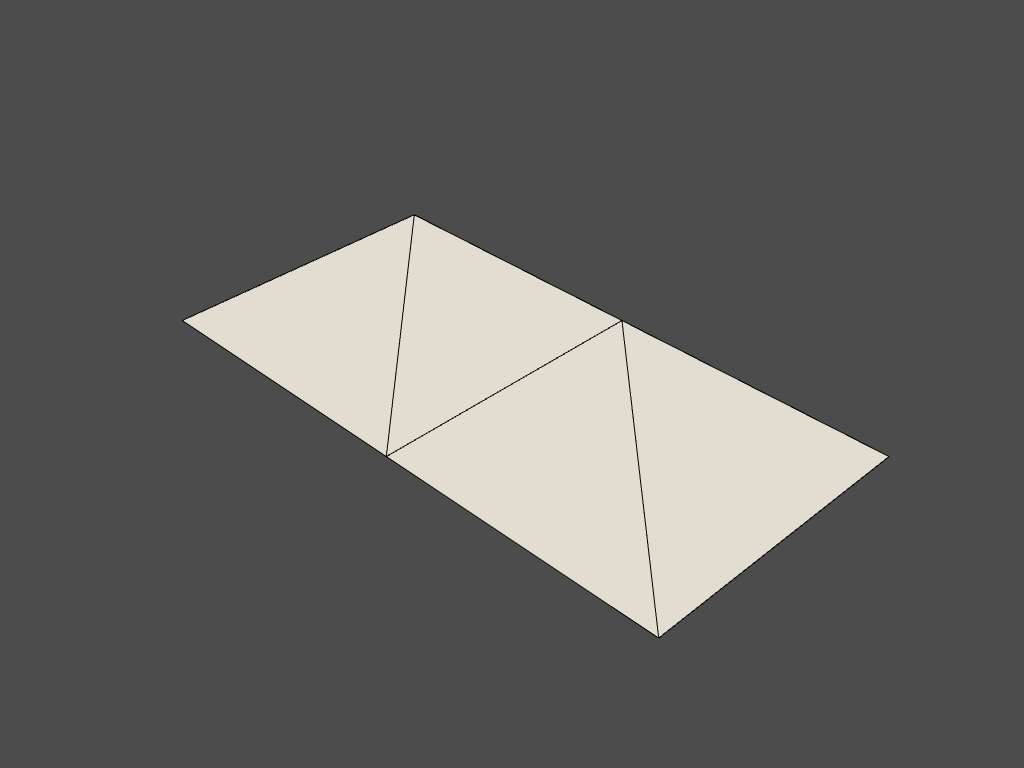

In [9]:
import pyvista as pv
import numpy as np

Points = np.array([[0, 1, 0],
                   [1, 1, 0],
                   [0, 0, 0],
                   [1, 0, 0],
                   [0, 0, 0],
                   [1, 0, 0],
                   [0,-1, 0],
                   [1,-1, 0]])
is_slave = np.array([0,0,0,0,1,1,0,0])
masters  = np.array([0,1,2,3,2,3,6,7])
N_points=len(Points)

# mesh faces
Cells = np.hstack([[3,2,1,0], 
                   [3,2,3,1], 
                   [3,6,5,4],
                   [3,6,7,5]])

surf = pv.PolyData(Points, Cells)
surf.plot(show_edges=True)
surf.save("simple.vtk", binary=False)

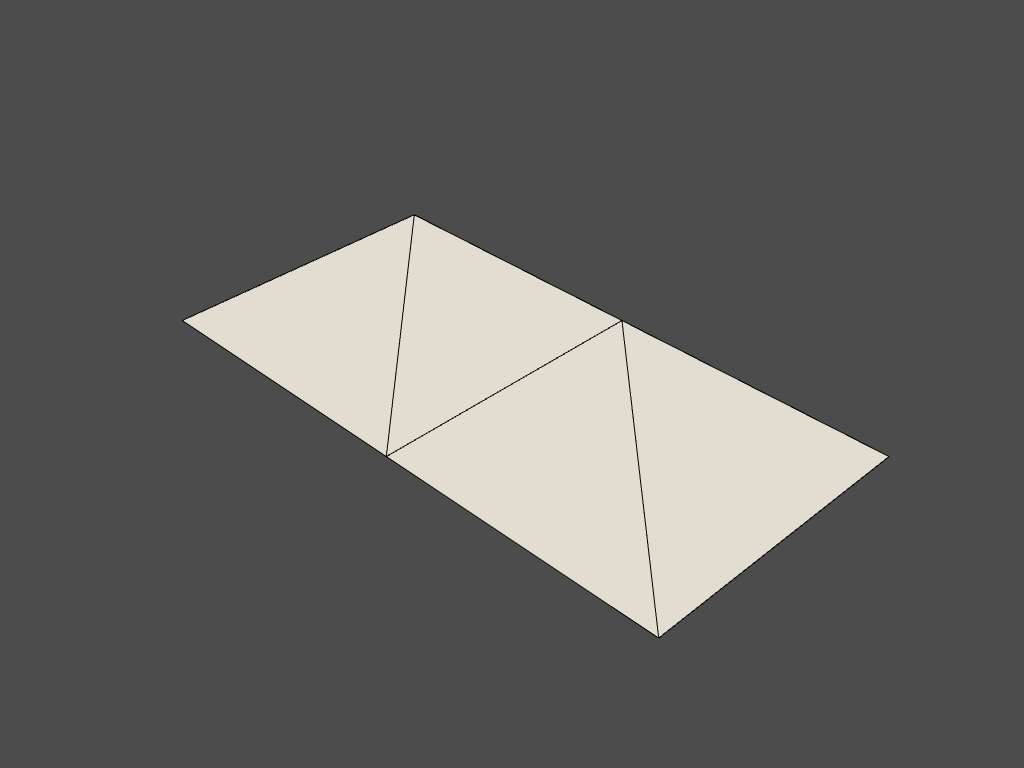

In [10]:
#Arreglo conectividad NON-MANIFOLD  sin Master-Slave

n=N_points
i=0

for j in range(0, N_points):           #para cada nodo 
    if (n<1):                         #cantidad de nodos restantes actualizada por los eliminados
        break
    if (is_slave[i]):                  #si es slave
        Points=np.delete(Points, i,0)  #lo elimino de la lista de puntos  [x,y,z]
        Cells[Cells==i]=masters[i]     #cada valor de conectividad == id_nodo_slave  pasa a ser =  a su nodo master
        Cells[Cells>i]-=1              #cada valor de conectividad mayor al id_nodo_slave pasa a ser -=1
        masters[np.where(masters[i:]>i)[0]+i]-=1 #quito uno a cada master q falta revisar si su master esta por encima de i (los q están por debajo no cambiaron su índice)
        is_slave=np.delete(is_slave, i)
        masters=np.delete(masters,i)
        i-=1                           #vuelvo al mismo índice, ahora tendrá un nuevo nodo
    n-=1                               #queda un nodo menos
    i+=1
    
Cells=Cells.reshape(int(len(Cells)/4),4)
surf = pv.PolyData(Points, Cells)
surf.plot(show_edges=True)
surf.save("simple.vtk", binary=False)

## Ejemplo integrado para malla Non-Manifold sin Master-Slave

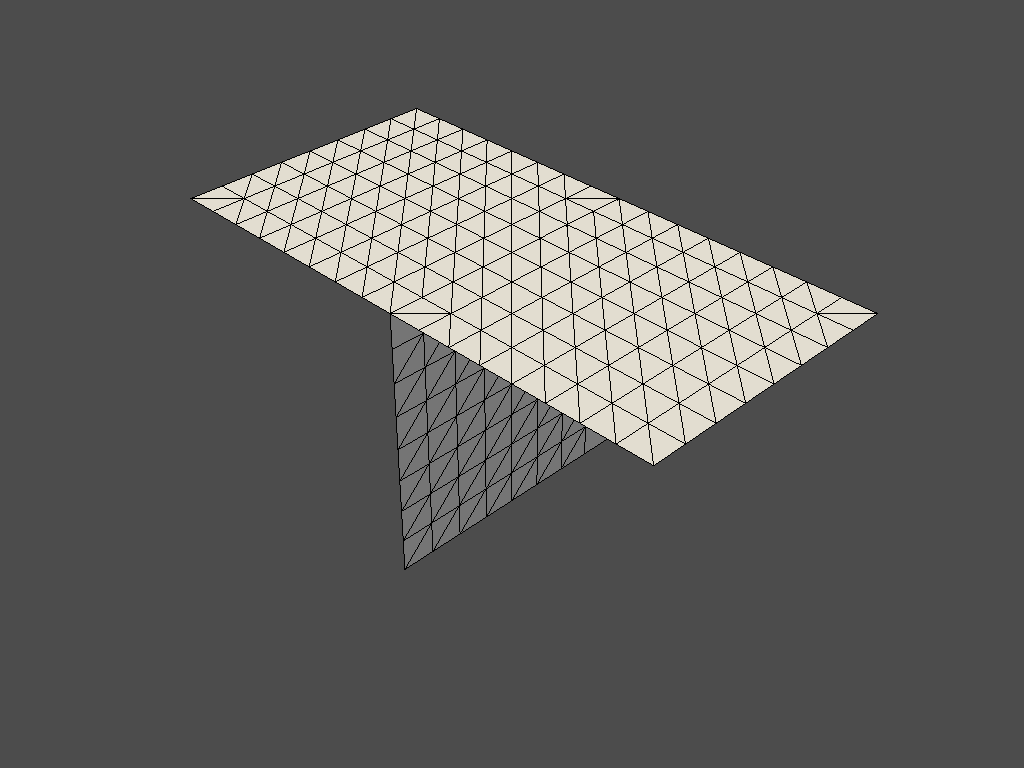

In [20]:
import pyvista as pv
import numpy as np
import vtk
from vtk.numpy_interface import dataset_adapter as dsa  # Para convertir de vtk a numpy

reader = vtk.vtkPolyDataReader()                        # SOURCE/READER 
reader.SetFileName('non_manifold_T_9x9.vtk')                   
reader.Update()                                          
data_vtk = reader.GetOutput()
data= dsa.WrapDataObject(data_vtk)                      # convierte la salida a array compatible con numpy

N_points = data.GetNumberOfPoints()                     # número de nodos

Points=np.array(data.Points)
Cells =np.array(data.Polygons)

unq, index = np.unique(data.Points,                     # filtro valores uniq del array de puntos
                       axis=0,                          # compara filas enteras
                       return_index=True)               # índice de los no repetidos

masters   = np.zeros(N_points,dtype=int)
is_slave  = np.zeros(N_points, dtype=int)
for i in range(0, N_points):                            # para cada nodo i
    if i in index:                                      # si es único
        masters[i] = i                                  # su master es i
        is_slave[i] = False                              
    else:                                               # si no es único
        for j in range(0,i):                            # comparo con cada nodo ANTERIOR  j
            if np.all(Points[i]==Points[j]):            # si es igual  al nodo j (el primero que aparece)
                masters[i] = j                          # su master es j
                is_slave[i] = True
                break                                   # detengo el bucle for

#Arreglo conectividad NON-MANIFOLD  sin Master-Slave =========================
n=N_points
i=0

for j in range(0, N_points):           #para cada nodo 
    if (n<1):                         #cantidad de nodos restantes actualizada por los eliminados
        break
    if (is_slave[i]):                  #si es slave
        Points=np.delete(Points, i,0)  #lo elimino de la lista de puntos  [x,y,z]
        Cells[Cells==i]=masters[i]     #cada valor de conectividad == id_nodo_slave  pasa a ser =  a su nodo master
        Cells[Cells>i]-=1              #cada valor de conectividad mayor al id_nodo_slave pasa a ser -=1
        masters[np.where(masters[i:]>i)[0]+i]-=1 #quito uno a cada master q falta revisar si su master esta por encima de i (los q están por debajo no cambiaron su índice)
        is_slave=np.delete(is_slave, i)
        masters=np.delete(masters,i)
        i-=1                           #vuelvo al mismo índice, ahora tendrá un nuevo nodo
    n-=1                               #queda un nodo menos
    i+=1
    
Cells=Cells.reshape(int(len(Cells)/4),4)
surf = pv.PolyData(Points, Cells)
surf.plot(show_edges=True)
surf.save('nonManifold_T_3x9x9_noMaster.vtk', binary=False)

In [2]:
import numpy as np
def find_points_where(lista_puntos,  x=None, y=None, z=None , tol=1e-8):  
    if (x!=None and y!=None and z!=None):            # x y z
        X = np.where(abs(lista_puntos[:,0]-x)<tol)
        Y = np.where(abs(lista_puntos[:,1]-y)<tol)
        Z = np.where(abs(lista_puntos[:,2]-z)<tol)
        XY= np.intersect1d(X,Y)
        XYZ= np.intersect1d(XY,Z)
        return XYZ
    
    if (x!=None and y!=None and z==None):            # x y -
        X = np.where(abs(lista_puntos[:,0]-x)<tol)
        Y = np.where(abs(lista_puntos[:,1]-y)<tol)
        XY= np.intersect1d(X,Y)
        return XY
    
    if (x!=None and y==None and z!=None):           # x - z
        X = np.where(abs(lista_puntos[:,0]-x)<tol)
        Z = np.where(abs(lista_puntos[:,2]-z)<tol)
        XZ= np.intersect1d(X,Z)
        return XZ
    
    if (x!=None and y==None and z==None):           # x - -
        X = np.where(abs(lista_puntos[:,0]-x)<tol)
        return X
    
    if (x==None and y!=None and z!=None):           # - y z
        Y = np.where(abs(lista_puntos[:,1]-y)<tol)
        Z = np.where(abs(lista_puntos[:,2]-z)<tol)
        YZ= np.intersect1d(Y,Z)
        return YZ
    
    if (x==None and y!=None and z==None):           # - y -
        Y = np.where(abs(lista_puntos[:,1]-y)<tol)
        return Y
    
    if (x==None and y==None and z!=None):           # - - z
        Z = np.where(abs(lista_puntos[:,2]-z)<tol)
        return Z    

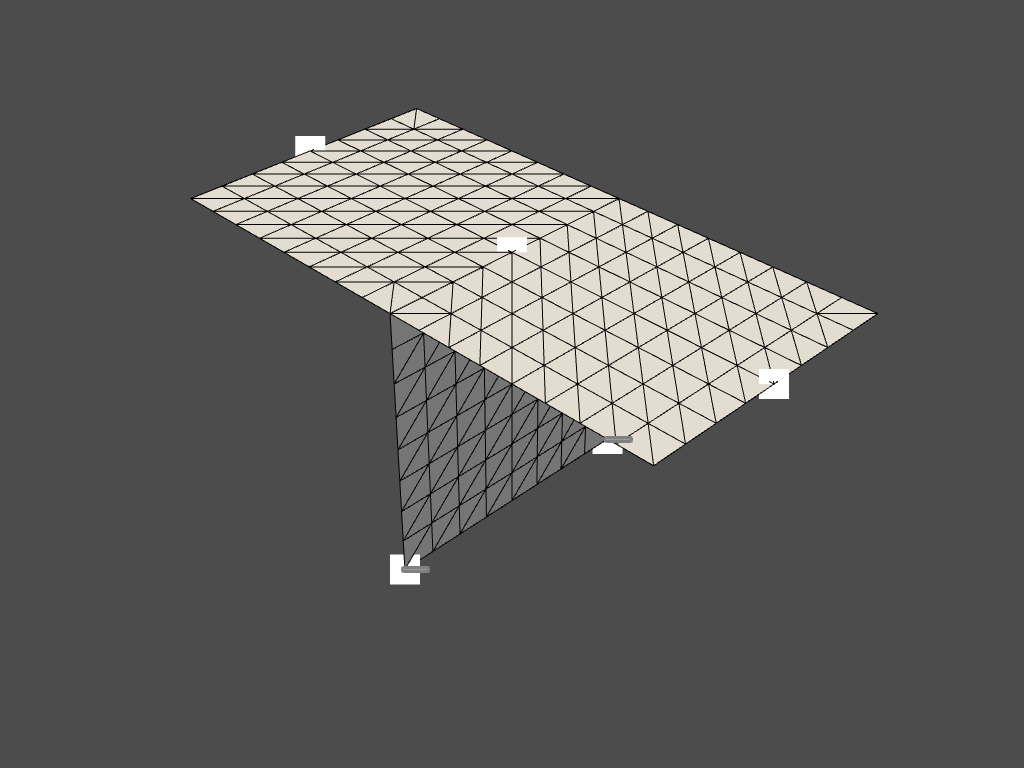

In [4]:
import pyvista as pv

plotter = pv.Plotter()
plotter.add_mesh(surf, show_edges=True, color="white")

# Add labels to points on the yz plane (where x == 0)
puntos = surf.points

c =find_points_where(puntos, x=.5, y=0, z=0)
cd=find_points_where(puntos, x=.5, y=1, z=0)
ci=find_points_where(puntos, x=.5, y=-1,z=0)
b1 =find_points_where(puntos, x=0, y=0, z=-1)
b2 =find_points_where(puntos, x=1,y=0, z=-1)
D =find_points_where(puntos, y=1, z=0)
I =find_points_where(puntos, y=-1,z=0)

constraints=np.zeros([len(puntos),3])
constraints[D,2]=1    
constraints[I,2]=1
constraints[ci,0]=1
constraints[cd,0]=1
constraints[b1,1]=1
constraints[b2,1]=1
constraints[c]=[1,1,0]

mask = np.concatenate((c,cd,ci,b2,b1), axis=0)
plotter.add_point_labels(
    puntos[mask], puntos[mask].tolist(), point_size=30, font_size=0)

plotter.show()

 # Identifico Creases, y constraint tags

In [21]:
import numpy as np
import vtk                   #install version 8 with: $ pip install vtk==8.1.2
from vtk.numpy_interface import dataset_adapter as dsa   

# Cargo archivo .vtk Non-Manifold  sin Master-Slave
reader = vtk.vtkPolyDataReader()                         
reader.SetFileName('nonManifold_T_3x9x9_noMaster.vtk')                   
reader.Update()                                          
data_vtk = reader.GetOutput()
data= dsa.WrapDataObject(data_vtk)  
puntos=np.array(data.Points)
N_points = data.GetNumberOfPoints()   

# Identifico Creases =========================================================
bordes = vtk.vtkFeatureEdges()                     
bordes.SetInputData(data_vtk)   
bordes.BoundaryEdgesOn()                           
bordes.FeatureEdgesOff()
bordes.Update()
b=bordes.GetOutput()
b.GetNumberOfPoints()

is_creases=np.zeros(N_points, dtype=int)   # array  vacío
for i in range(0,N_points):                # Para cada nodo de la malla  i
    p=data_vtk.GetPoint(i)                 # obtengo  su posición [x,y,z]  
    B_point=b.GetPoint(b.FindPoint(p))     # de los puntos del borde, busco el más cercano [a x,y,z]
    val=B_point==p                         # verifico si ese nodo es del borde
    is_creases[i]=val                      # guarda 1 si es del borde, 0 si no 
    
# Identifico Constraint tags =================================================
c =find_points_where(puntos, x=.5, y=0, z=0)
cd=find_points_where(puntos, x=.5, y=1, z=0)
ci=find_points_where(puntos, x=.5, y=-1,z=0)
b1=find_points_where(puntos, x=0 , y=0, z=-1)
b2=find_points_where(puntos, x=1 , y=0, z=-1)
D =find_points_where(puntos, y=1 , z=0)
I =find_points_where(puntos, y=-1, z=0)

constraints=np.zeros([len(puntos),3])
constraints[c,0]=1
constraints[c,1]=1
constraints[D,2]=1    
constraints[I,2]=1
constraints[ci,0]=1
constraints[cd,0]=1
constraints[b1,1]=1
constraints[b2,1]=1
constraints[c]=[1,1,0]

# Creases con corner=2 ???????????????????????????????????????????????????????
c1 =find_points_where(puntos, x=0, y=1, z=0)
c2 =find_points_where(puntos, x=1, y=1, z=0)
c3 =find_points_where(puntos, x=0, y=-1, z=0)
c4 =find_points_where(puntos, x=1, y=-1, z=0)
b3=find_points_where(puntos, x=0 , y=0, z=0)
b4=find_points_where(puntos, x=1 , y=0, z=0)
is_creases[np.array([c1,c2,c3,c4,b1,b2,b3,b4])]=2

# Guardo un nuevo archivo .vtk ===============================================
Is_creases=dsa.numpyTovtkDataArray(is_creases,name = "CreasesId") # convierto la lista master a un objeto vtkDataArray 
data_vtk.GetPointData().SetScalars(Is_creases)                    # para agregar un segundo atributo uso AddArray()      ver http://vtk.1045678.n5.nabble.com/Multiple-fields-scalars-vectors-td1224224.html

Constraints=dsa.numpyTovtkDataArray(constraints,name = "ConstraintTags")
data_vtk.GetPointData().AddArray(Constraints)   

#data_vtk.GetPointData().

writer = vtk.vtkPolyDataWriter()                          
writer.SetFileName('non_manifold_full.vtk')           
writer.SetInputData(data_vtk)                            
writer.SetFileType(1)         # opcional: set file type to ascii
if writer.Write():            # escribo el archivo .vtk  Returns 1 on success and 0 on failure.
    print("Archivo vtk guardado")                
del(writer)

# Boudary displacement file ==================================================
base=find_points_where(puntos, y=0, z=-1)
n_displ =len(base)
dis=np.zeros([n_displ, 7], dtype=int)
dis[:,0]= base
dis[:,3]=1
dis[:,6]=1

header=str(n_displ)+' '+str(7)
np.savetxt('BDispl.pts', dis , delimiter='        ', fmt='%u', header=header)

Archivo vtk guardado


# Nodos con desplazamiento impuesto Bdispl